In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import labeling_network as lbln
from matplotlib import pyplot as plt
import theano
import theano.tensor as T
import numpy as np
from labeling_network import FullyConnectedLayer, ConvPoolLayer

Running with a CPU.  If this is not desired, then the modify network3.py to set
the GPU flag to True.


In [3]:
train_data, valid_data, test_data = lbln.load_data_shared(
                     '../../TrainingData/LabeledData-2015-09-06/',
                     'capture',
                     '../../TrainingData/LabeledData-2015-09-06/labels.dat',
                      n_train=30000,
                      n_validation=3000,
                      n_test=2000,
                      label_mask=0)

In [4]:
mini_batch_size = 10

In [5]:
network = lbln.Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 3, 64, 64), 
                      filter_shape=(20, 3, 5, 5), 
                      poolsize=(4, 4)),
        FullyConnectedLayer(n_in=15*15*20, n_out=100),
        FullyConnectedLayer(n_in=100, n_out=5)
#         FullyConnectedLayer(n_in=150, n_out=5)
    ], mini_batch_size)

In [6]:
network.SGD(train_data, 
            80, 
            mini_batch_size, 
            0.05, 
            valid_data, 
            test_data,
            lmbda=0.01)

--- Training mini-batch number 0 ---
--- Training mini-batch number 1000 ---
--- Training mini-batch number 2000 ---
  Epoch 0: validation accuracy -0.050143
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.048378
    Current cost on training set: 0.0494858698733
--- Training mini-batch number 3000 ---
--- Training mini-batch number 4000 ---
--- Training mini-batch number 5000 ---
  Epoch 1: validation accuracy -0.050119
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.048359
    Current cost on training set: 0.0491787816385
--- Training mini-batch number 6000 ---
--- Training mini-batch number 7000 ---
--- Training mini-batch number 8000 ---
  Epoch 2: validation accuracy -0.050097
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.048341
    Current cost on training set: 0.0491591536671
--- Training mini-batch number 9000 ---
--- Training mini-batch num

In [ ]:
import pylab
pylab.rcParams['figure.figsize'] = (6.0, 6.0)

In [8]:
def determine_test_accuracy(net, xs, ts, offset, allowed_dev):
    assert len(xs) == len(ts)
    errors = 0
    for x, t in zip(xs, ts):
        prediction = net.get_single_output(x)
#         print 't:', t
#         print 'p:', prediction
#         print abs(t - prediction) / (t + offset)
        
#         print (t-offset)/allowed_dev
#         print (t+offset)*allowed_dev
#         print np.greater(prediction - (t-offset)/allowed_dev, 0)
#         print np.greater((t+offset)*allowed_dev - prediction, 0)
        err = 1 - np.prod(np.greater(prediction - (t-offset)/allowed_dev, 0)) * np.prod(np.greater((t+offset)*allowed_dev - prediction, 0))
#         if err == 1:
#             print t
#             print prediction
#             print np.greater(prediction - (t-offset)/allowed_dev, 0)
#             print np.greater((t+offset)*allowed_dev - prediction, 0)
#             print
        errors += err
        
#         if np.max(abs(t - prediction) / (t + offset)) > allowed_dev:
#             print '(error)'
#             errors += 1
    return (1.0 * len(xs)-errors) / len(xs)

In [ ]:
# minibatch = 1
# index = 8

# im = test_data[0].get_value()[minibatch*mini_batch_size + index].reshape(64, 64, 3)
# plt.imshow(im, interpolation='nearest')

# network_function = theano.function([network.x], network.output)

# prediction = network_function(test_data[0].get_value()[minibatch*mini_batch_size: (minibatch+1)*mini_batch_size])[index]
# actual = test_data[1].get_value()[minibatch*mini_batch_size + index]

# print prediction
# print
# print actual


# # print determine_test_accuracy(network, test_data[0].get_value(), test_data[1].get_value(), 0.2, 1.2)

# print 
# print 'Mean predicted output', np.mean(prediction)
# print 'Mean actual output', np.mean(actual)
# print 'Squared error:', np.mean((actual - prediction) ** 2)
# # print 'Loss', np.mean(-np.log(1.0000001 - np.abs(prediction - actual)))

In [9]:
print determine_test_accuracy(network, test_data[0].get_value(), test_data[1].get_value(), 0.2, 1.2)

0.6895


In [11]:
test_data_xs = test_data[0].get_value()
test_data_ts = test_data[1].get_value()

Worst prediction:
Target:     [ 1.         1.         0.9600002  0.         0.       ]
Prediction: [ 0.0911787   0.2829724   0.52669997  0.53244168  0.57604275]


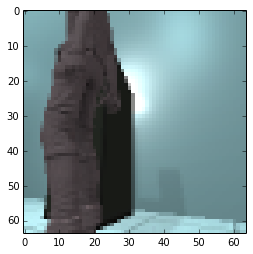

In [12]:
# Determine all errors on the test images
classifications = []
for x, t in zip(test_data_xs, test_data_ts):
    prediction = network.get_single_output(x)
    error = np.mean((t - prediction) ** 2)
    classifications.append((x, t, prediction, error))

classifications = sorted(classifications, key = lambda (x, t, p, e): e, reverse=True)

print 'Worst prediction:'
print 'Target:    ', classifications[0][1]
print 'Prediction:', classifications[0][2]
plt.imshow(classifications[0][0].reshape(64, 64, 3), interpolation='nearest')
plt.show()


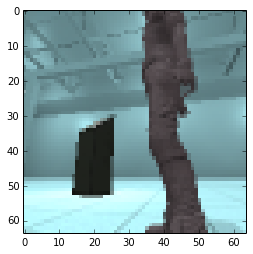

t: [ 0.    0.04  1.    1.    1.  ]
p: [ 0.11738705  0.50542674  0.674132    0.91983199  0.80418152]
d: 0.0762727019911


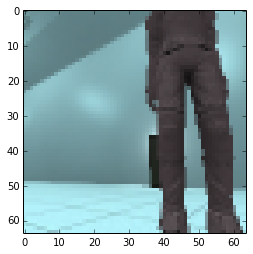

t: [ 0.    0.    0.68  1.    1.  ]
p: [ 0.11514481  0.24921515  0.77804485  0.94969207  0.9399163 ]
d: 0.0182240491563


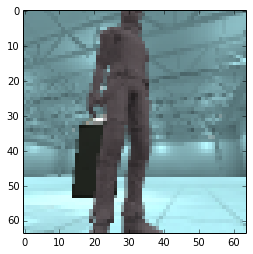

t: [ 0.08  1.    1.    0.64  0.  ]
p: [ 0.72409942  0.96899065  0.9359159   0.41521881  0.06704657]
d: 0.0949908480914


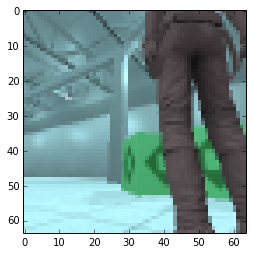

t: [ 0.         0.         0.9600002  1.         1.       ]
p: [ 0.16127437  0.42161869  0.68674216  0.92685121  0.94165925]
d: 0.0574392174242


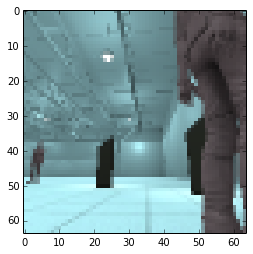

t: [ 0.4399999  0.         0.28       1.         1.       ]
p: [ 0.06479628  0.14234375  0.44240662  0.87278173  0.90453625]
d: 0.0425426450128


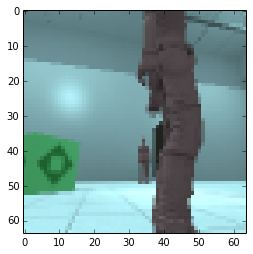

t: [ 0.    0.32  1.    1.    1.  ]
p: [ 0.38304241  0.4056874   0.75376591  0.8532731   0.88723215]
d: 0.0497880828233


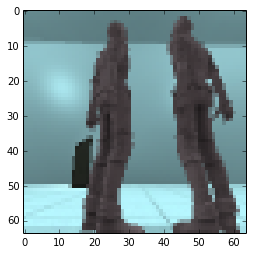

t: [ 0.36  1.    1.    1.    1.  ]
p: [ 0.24768637  0.77001873  0.86370057  0.78110139  0.47877709]
d: 0.0807346387968


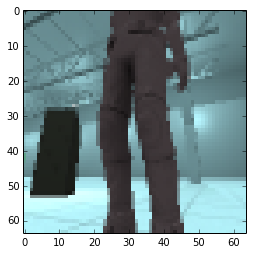

t: [ 0.3999999  1.         1.         1.         0.9200001]
p: [ 0.7215284   0.8351693   0.87477335  0.62769501  0.37574183]
d: 0.116211904699


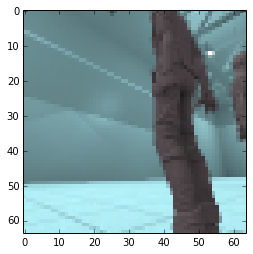

t: [ 0.    0.    0.68  1.    1.  ]
p: [ 0.1261271   0.45121159  0.48478099  0.83348293  0.56979891]
d: 0.0940822650263


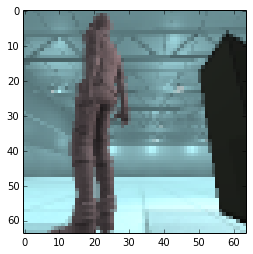

t: [ 0.72       1.         0.8800001  0.         0.       ]
p: [ 0.57232007  0.50665838  0.69394565  0.50157141  0.51873927]
d: 0.164095179046


In [13]:
high_signal_images = np.asarray([(x, t) for (x, t) in zip(test_data_xs, test_data_ts) if np.mean(t) > 0.5])

for x, t in high_signal_images[:10]:
    prediction = network.get_single_output(x)
    plt.imshow(x.reshape(64, 64, 3), interpolation='nearest')
    plt.show()
    print 't:', t
    print 'p:', prediction
    print 'd:', np.mean((t - prediction) ** 2)


In [ ]:
testfun = theano.function([network.x_single], network.layers[0].single_output)

In [ ]:
testfun(test_data[0].get_value()[9]).shape

In [ ]:
## AVERAGE SQUARED MAGNITUDE OF SENSOR VALUES:
# for t in test_data[1].get_value()[:10]:
#     print t, t ** 2, np.mean(t ** 2)

test_targets = train_data[1].get_value()

print np.mean(test_targets)

print np.mean(test_targets ** 2)

print np.mean((test_targets - np.mean(test_targets)) ** 2)